In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle, resample
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# ==== 1. Load và nối dữ liệu đã scale ====
file_list = [
    "scaled_files/keypoints_cut_by_frame_id_1_scaled.csv",
    "scaled_files/keypoints_cut_by_frame_id_2_scaled.csv",
    "scaled_files/keypoints_cut_by_frame_id_3_scaled.csv",
    "scaled_files/keypoints_cut_by_frame_id_5_scaled.csv",
]
dataframes = [pd.read_csv(f) for f in file_list]
data = pd.concat(dataframes, ignore_index=True)

# ==== 2. Gộp nhãn thành 2 nhóm ====
normal_labels = ["Sitting quietly", "Walking", "Eating snacks", "Using phone"]
abnormal_labels = ["Attacking", "Biting", "Throwing things", "Head banging"]
data['Group'] = data['Action Label'].apply(lambda x: 'Normal' if x in normal_labels else 'Abnormal')

# ==== 3. Encode nhãn 2 lớp ====
data['Group_Label'] = data['Group'].map({'Normal': 0, 'Abnormal': 1})

# ==== 4. Oversampling lớp ít ====
normal_data = data[data['Group_Label'] == 0]
abnormal_data = data[data['Group_Label'] == 1]

if len(abnormal_data) < len(normal_data):
    abnormal_upsampled = resample(abnormal_data,
                                   replace=True,
                                   n_samples=len(normal_data),
                                   random_state=42)
    data_balanced = pd.concat([normal_data, abnormal_upsampled])
else:
    normal_upsampled = resample(normal_data,
                                 replace=True,
                                 n_samples=len(abnormal_data),
                                 random_state=42)
    data_balanced = pd.concat([normal_upsampled, abnormal_data])

data_balanced = shuffle(data_balanced, random_state=42).reset_index(drop=True)

# ==== 5. Tách X, y ====
X = data_balanced.iloc[:, 1:-3].values  # Bỏ frame_id, Action Label, Group, Group_Label
y = data_balanced['Group_Label'].values

# ==== 6. Chuẩn hóa và PCA ====
pca = PCA(n_components=34)
X_pca = pca.fit_transform(X)

# ==== 7. Train-test split ====
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# ==== 8. Build model ====
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(34,)))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))  # binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ==== 9. Train ====
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)

# ==== 10. Evaluate ====
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("✅ Classification Report (Binary):")
print(classification_report(y_test, y_pred, target_names=["Normal", "Abnormal"]))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4480      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 12801 (50.00 KB)
Trainable params: 12801 (50.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
11000/110

In [5]:
import pandas as pd
import numpy as np

# ==== 1. Đọc file mới đã scale ====
new_data = pd.read_csv('scaled_files/test data_keypoint_scaled.csv')  # chưa có nhãn

# ==== 2. Lấy feature để dự đoán (loại frame_id, Action Label nếu có) ====
X_new = new_data.iloc[:, 1:].values
#X_new_scaled = scaler.transform(X_new)       # sử dụng scaler đã fit trước đó
X_new_pca = pca.transform(X_new)
# ==== 3. Dự đoán bằng mô hình binary ====
y_pred_prob = model.predict(X_new_pca)
y_pred_class = (y_pred_prob > 0.5).astype(int).flatten()

# ==== 4. Gán nhãn văn bản: 0 → Normal, 1 → Abnormal ====
label_map = {0: 'Normal', 1: 'Abnormal'}
predicted_labels = [label_map[i] for i in y_pred_class]

# ==== 5. Thêm vào DataFrame ====
new_data['Predicted_Label'] = predicted_labels
normal_df = new_data[new_data['Predicted_Label'] == 'Normal']
abnormal_df = new_data[new_data['Predicted_Label'] == 'Abnormal']

normal_df.to_csv('predicted_normal.csv', index=False)
abnormal_df.to_csv('predicted_abnormal.csv', index=False)
print("✅ Đã lưu predicted_normal.csv và predicted_abnormal.csv")
# ==== 6. Lưu kết quả ====
new_data.to_csv('new_file_with_prediction.csv', index=False)
print("✅ Dự đoán xong. Đã lưu vào: new_file_with_prediction.csv")


3686/3686 [==============================] - 13s 4ms/step
✅ Đã lưu predicted_normal.csv và predicted_abnormal.csv
✅ Dự đoán xong. Đã lưu vào: new_file_with_prediction.csv


In [19]:
df = pd.read_csv('new_file_with_prediction.csv')
new_data = pd.read_csv('test data_keypoint.csv')
new_data['Predicted_Label'] = df['Predicted_Label']
normal_df = new_data[new_data['Predicted_Label'] == 'Normal']
abnormal_df = new_data[new_data['Predicted_Label'] == 'Abnormal']

normal_df.to_csv('test_predicted_normal.csv', index=False)
abnormal_df.to_csv('test_predicted_abnormal.csv', index=False)

Epoch 1/30
214/214 [==============================] - 64s 230ms/step - loss: 0.8480 - accuracy: 0.6163 - val_loss: 0.4596 - val_accuracy: 0.8248 - lr: 0.0010
Epoch 2/30
214/214 [==============================] - 50s 233ms/step - loss: 0.5254 - accuracy: 0.7717 - val_loss: 0.4047 - val_accuracy: 0.8340 - lr: 0.0010
Epoch 3/30
214/214 [==============================] - 40s 185ms/step - loss: 0.3710 - accuracy: 0.8488 - val_loss: 0.3748 - val_accuracy: 0.8485 - lr: 0.0010
Epoch 4/30
214/214 [==============================] - 39s 182ms/step - loss: 0.3216 - accuracy: 0.8651 - val_loss: 0.3476 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 5/30
214/214 [==============================] - 79s 370ms/step - loss: 0.2774 - accuracy: 0.8882 - val_loss: 0.4004 - val_accuracy: 0.8090 - lr: 0.0010
Epoch 6/30
214/214 [==============================] - 43s 200ms/step - loss: 0.2583 - accuracy: 0.8999 - val_loss: 0.2464 - val_accuracy: 0.8893 - lr: 0.0010
Epoch 7/30
214/214 [==============================] 

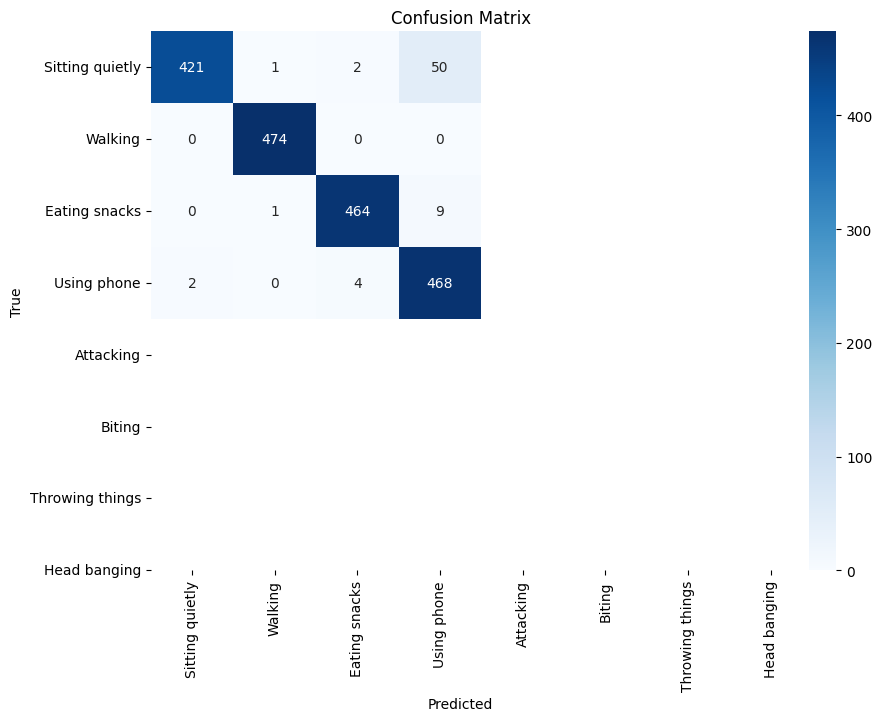

88/88 [==============================] - 8s 87ms/step
✅ Saved predictions to normal.csv


In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, MultiHeadAttention, GlobalAveragePooling1D, LayerNormalization,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==== CONFIGURATION ====
SEQ_LEN = 30
OVERSAMPLE = True
USE_NORMALIZE = True
USE_PCA = False
PCA_COMPONENTS = 90

# ==== LABELS ====
normal_labels = ['Sitting quietly', 'Walking', 'Eating snacks', 'Using phone']
abnormal_labels = ['Attacking', 'Biting', 'Throwing things', 'Head banging']
NUM_CLASSES = len(normal_labels) 

# ==== 1. Interpersonal normalization ====
def interpersonal_normalize(df):
    if not USE_NORMALIZE:
        return df
    lx, ly = df['left_shoulder_x'], df['left_shoulder_y']
    rx, ry = df['right_shoulder_x'], df['right_shoulder_y']
    dist = np.sqrt((rx - lx)**2 + (ry - ly)**2) + 1e-6
    for c in df.columns:
        if c.endswith('_x') or c.endswith('_y'):
            df[c] = df[c] / dist
    return df

# ==== 2. Feature Engineering ====
def compute_distance(df, p1x, p1y, p2x, p2y, name):
    return np.sqrt((df[p1x] - df[p2x])**2 + (df[p1y] - df[p2y])**2).rename(name)

def compute_velocity_features(df, feature_cols):
    vel_features = []
    for col in feature_cols:
        vel = df[col].diff().fillna(0)
        vel_features.append(vel.rename(f"{col}_vel"))
    return pd.concat(vel_features, axis=1)

def compute_advanced_features(df):
    df['hand_to_mouth'] = compute_distance(df, 'nose_x', 'nose_y', 'right_wrist_x', 'right_wrist_y', 'hand_to_mouth')
    df['hip_sway'] = compute_distance(df, 'left_hip_x', 'left_hip_y', 'right_hip_x', 'right_hip_y', 'hip_sway')
    df['hand_speed'] = np.sqrt(df['right_wrist_x'].diff().fillna(0)**2 + df['right_wrist_y'].diff().fillna(0)**2)
    df['head_speed'] = np.sqrt(df['nose_x'].diff().fillna(0)**2 + df['nose_y'].diff().fillna(0)**2)
    df['hand_near_mouth'] = (df['hand_to_mouth'] < 0.12).astype(int).rolling(window=5, min_periods=1).mean()
    df['hand_near_head'] = compute_distance(df, 'right_wrist_x', 'right_wrist_y', 'right_shoulder_x', 'right_shoulder_y', 'hand_near_head')
    
    return df

# ==== 3. Load & preprocess ====
file_list = [
    'split_files/keypoints_cut_by_frame_id_1_normal.csv',
    'split_files/keypoints_cut_by_frame_id_2_normal.csv',
    'split_files/keypoints_cut_by_frame_id_3_normal.csv',
    'split_files/keypoints_cut_by_frame_id_5_normal.csv',
]
dfs = []
for path in file_list:
    df = pd.read_csv(path)
    df = interpersonal_normalize(df)
    df['hand_dist'] = compute_distance(df, 'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y', 'hand_dist')
    df['head_hand_left'] = compute_distance(df, 'nose_x', 'nose_y', 'left_wrist_x', 'left_wrist_y', 'head_hand_left')
    df['head_hand_right'] = compute_distance(df, 'nose_x', 'nose_y', 'right_wrist_x', 'right_wrist_y', 'head_hand_right')
    df = compute_advanced_features(df)
    vel_df = compute_velocity_features(df, [c for c in df.columns if c.endswith('_x') or c.endswith('_y')])
    df = pd.concat([df, vel_df], axis=1)
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

data['Label'] = data['Action Label'].apply(
    lambda x: normal_labels.index(x) if x in normal_labels else len(normal_labels) + abnormal_labels.index(x)
)

# ==== 4. Sequence generation ====
def create_sequences(df, feature_cols, seq_len=SEQ_LEN, label_col='Label'):
    X, y = [], []
    for i in range(0, len(df) - seq_len + 1, seq_len):
        chunk = df.iloc[i:i+seq_len]
        if len(chunk) < seq_len:
            break
        label_counts = chunk[label_col].value_counts()
        if label_counts.iloc[0] < 0.7 * seq_len:
            continue
        seq = chunk[feature_cols].values
        label = label_counts.index[0]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

feature_cols = [c for c in data.columns if (
    c.endswith('_x') or c.endswith('_y') or '_vel' in c or 'hand_dist' in c or 'head_hand' in c or 
    'hand_to_mouth' in c or 'hip_sway' in c or 'hand_speed' in c or 'head_speed' in c or 
    'hand_near_mouth' in c or 'hand_near_head' in c
)]
X, y = create_sequences(data, feature_cols)

# ==== 5. Oversample ====
if OVERSAMPLE:
    N, T, D = X.shape
    X2 = X.reshape(N, T*D)
    df_seq = pd.DataFrame(X2)
    df_seq['label'] = y
    groups = df_seq.groupby('label')
    max_count = groups.size().max()
    frames = [grp.sample(max_count, replace=True, random_state=42) for _, grp in groups]
    df_bal = pd.concat(frames).sample(frac=1, random_state=42)
    y = df_bal['label'].values
    X2 = df_bal.drop(columns='label').values
    X = X2.reshape(-1, T, D)

# ==== 6. Optional PCA ====
if USE_PCA:
    N, T, D = X.shape
    Xflat = X.reshape(N, T*D)
    pca = PCA(n_components=min(PCA_COMPONENTS, Xflat.shape[1])).fit(Xflat)
    Xp = pca.transform(Xflat)
    Dp = Xp.shape[1] // T
    X = Xp.reshape(N, T, Dp)

# ==== 7. Train-test split ====
Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ==== 8. Build model ====
def build_attention_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Dropout(0.2)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_attention_lstm((SEQ_LEN, X.shape[2]), NUM_CLASSES)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ==== Class Weights ====
classes = np.unique(ytr)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=ytr)
# Build full class_weight_dict from 0 to NUM_CLASSES - 1
class_weight_dict = {i: 1.0 for i in range(NUM_CLASSES)}  # default
computed_weights = dict(zip(classes, class_weights))
class_weight_dict.update(computed_weights)


# ==== 9. Train ====
model.fit(
    Xtr, ytr,
    validation_split=0.1,
    epochs=30,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True), lr_scheduler],
    verbose=1,
    class_weight=class_weight_dict
)

# ==== 10. Evaluate ====
y_pred = np.argmax(model.predict(Xte), axis=1)
print("\n=== Classification Report ===")
print(classification_report(yte, y_pred))

# ==== 11. Confusion Matrix ====
cm = confusion_matrix(yte, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=normal_labels + abnormal_labels, yticklabels=normal_labels + abnormal_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ==== 12. Predict Function ====
def predict_sequences(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    df_raw = df.copy()
    df = interpersonal_normalize(df)
    
    # Compute features
    df['hand_dist'] = compute_distance(df, 'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y', 'hand_dist')
    df['head_hand_left'] = compute_distance(df, 'nose_x', 'nose_y', 'left_wrist_x', 'left_wrist_y', 'head_hand_left')
    df['head_hand_right'] = compute_distance(df, 'nose_x', 'nose_y', 'right_wrist_x', 'right_wrist_y', 'head_hand_right')
    df = compute_advanced_features(df)
    vel_df = compute_velocity_features(df, [c for c in df.columns if c.endswith('_x') or c.endswith('_y')])
    df = pd.concat([df, vel_df], axis=1)

    # Tạo chuỗi (không cần nhãn)
    def create_sequences_for_predict(df, feature_cols, seq_len=SEQ_LEN):
        X = []
        total_len = len(df)
        num_full_chunks = total_len // seq_len
        for i in range(0, num_full_chunks * seq_len, seq_len):
            chunk = df.iloc[i:i+seq_len]
            X.append(chunk[feature_cols].values)

        # Xử lý phần dư
        leftover = total_len % seq_len
        if leftover > 0:
            last_chunk = df.iloc[-leftover:][feature_cols].values
            padding = np.zeros((seq_len - leftover, len(feature_cols)))
            padded_seq = np.vstack([last_chunk, padding])
            X.append(padded_seq)

        return np.array(X)
    
    X_pred = create_sequences_for_predict(df, feature_cols, seq_len=SEQ_LEN)

    if USE_PCA:
        Xflat = X_pred.reshape(len(X_pred), -1)
        Xp = pca.transform(Xflat)
        X_pred = Xp.reshape(len(X_pred), SEQ_LEN, -1)

    # Dự đoán
    y_pred = np.argmax(model.predict(X_pred), axis=1)
    labels = [normal_labels[p] if p < len(normal_labels) else abnormal_labels[p - len(normal_labels)] for p in y_pred]

    # Gán nhãn dự đoán vào dataframe
    res = []
    total_chunks = len(labels)
    for i in range(total_chunks):
        start = i * SEQ_LEN
        end = min(start + SEQ_LEN, len(df_raw))
        chunk = df_raw.iloc[start:end].copy()
        chunk['Action Label'] = labels[i]
        res.append(chunk)
    
    df_pred = pd.concat(res, ignore_index=True)
    df_pred.to_csv(output_csv, index=False)
    print(f"✅ Saved predictions to {output_csv}")


# Example usage:
predict_sequences('test_predicted_normal.csv', 'normal.csv')


Epoch 1/30
69/69 [==============================] - 34s 185ms/step - loss: 0.9456 - accuracy: 0.5963 - val_loss: 0.4927 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 2/30
69/69 [==============================] - 7s 108ms/step - loss: 0.6383 - accuracy: 0.7327 - val_loss: 0.4627 - val_accuracy: 0.8354 - lr: 0.0010
Epoch 3/30
69/69 [==============================] - 8s 111ms/step - loss: 0.5269 - accuracy: 0.8009 - val_loss: 0.4430 - val_accuracy: 0.8025 - lr: 0.0010
Epoch 4/30
69/69 [==============================] - 7s 108ms/step - loss: 0.4379 - accuracy: 0.8320 - val_loss: 0.3398 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 5/30
69/69 [==============================] - 7s 109ms/step - loss: 0.3953 - accuracy: 0.8494 - val_loss: 0.4104 - val_accuracy: 0.8189 - lr: 0.0010
Epoch 6/30
69/69 [==============================] - 8s 110ms/step - loss: 0.3575 - accuracy: 0.8705 - val_loss: 0.4984 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 7/30
69/69 [==============================] - ETA: 0s - loss: 0

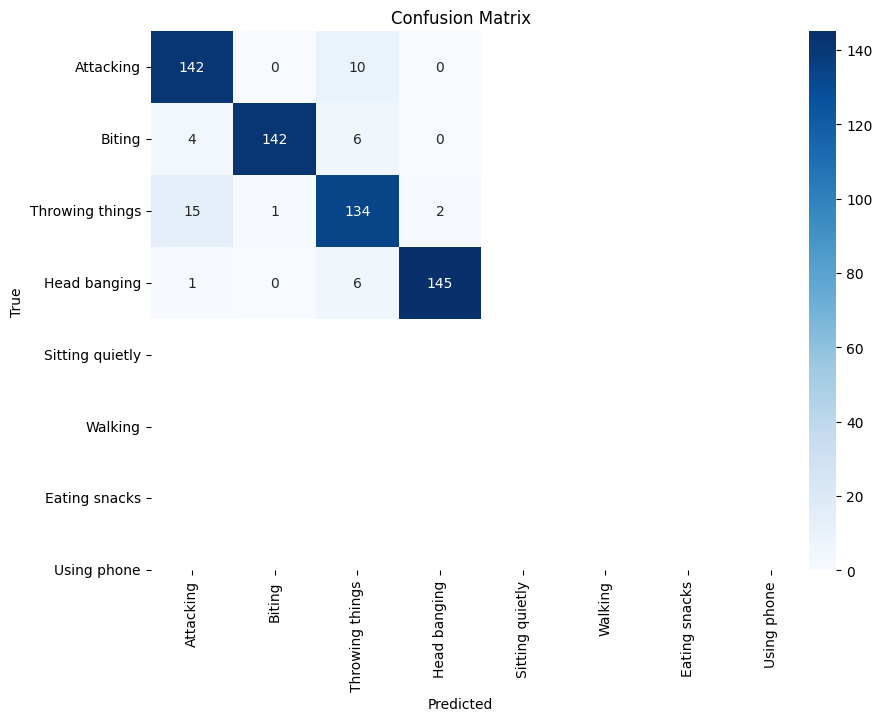

36/36 [==============================] - 3s 45ms/step
✅ Saved predictions to abnormal.csv


In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, MultiHeadAttention, GlobalAveragePooling1D, LayerNormalization,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==== CONFIGURATION ====
SEQ_LEN = 30
OVERSAMPLE = True
USE_NORMALIZE = True
USE_PCA = False
PCA_COMPONENTS = 90

# ==== LABELS ====
normal_labels = ['Sitting quietly', 'Walking', 'Eating snacks', 'Using phone']
abnormal_labels = ['Attacking', 'Biting', 'Throwing things', 'Head banging']
NUM_CLASSES = len(abnormal_labels) 

# ==== 1. Interpersonal normalization ====
def interpersonal_normalize(df):
    if not USE_NORMALIZE:
        return df
    lx, ly = df['left_shoulder_x'], df['left_shoulder_y']
    rx, ry = df['right_shoulder_x'], df['right_shoulder_y']
    dist = np.sqrt((rx - lx)**2 + (ry - ly)**2) + 1e-6
    for c in df.columns:
        if c.endswith('_x') or c.endswith('_y'):
            df[c] = df[c] / dist
    return df

# ==== 2. Feature Engineering ====
def compute_distance(df, p1x, p1y, p2x, p2y, name):
    return np.sqrt((df[p1x] - df[p2x])**2 + (df[p1y] - df[p2y])**2).rename(name)

def compute_velocity_features(df, feature_cols):
    vel_features = []
    for col in feature_cols:
        vel = df[col].diff().fillna(0)
        vel_features.append(vel.rename(f"{col}_vel"))
    return pd.concat(vel_features, axis=1)

def compute_advanced_features(df):
    df['hand_to_mouth'] = compute_distance(df, 'nose_x', 'nose_y', 'right_wrist_x', 'right_wrist_y', 'hand_to_mouth')
    df['hip_sway'] = compute_distance(df, 'left_hip_x', 'left_hip_y', 'right_hip_x', 'right_hip_y', 'hip_sway')
    df['hand_speed'] = np.sqrt(df['right_wrist_x'].diff().fillna(0)**2 + df['right_wrist_y'].diff().fillna(0)**2)
    df['head_speed'] = np.sqrt(df['nose_x'].diff().fillna(0)**2 + df['nose_y'].diff().fillna(0)**2)
    df['hand_near_mouth'] = (df['hand_to_mouth'] < 0.12).astype(int).rolling(window=5, min_periods=1).mean()
    df['hand_near_head'] = compute_distance(df, 'right_wrist_x', 'right_wrist_y', 'right_shoulder_x', 'right_shoulder_y', 'hand_near_head')
    
    return df

# ==== 3. Load & preprocess ====
file_list = [
    'split_files/keypoints_cut_by_frame_id_1_abnormal.csv',
    'split_files/keypoints_cut_by_frame_id_2_abnormal.csv',
    'split_files/keypoints_cut_by_frame_id_3_abnormal.csv',
    'split_files/keypoints_cut_by_frame_id_5_abnormal.csv',
]
dfs = []
for path in file_list:
    df = pd.read_csv(path)
    df = interpersonal_normalize(df)
    df['hand_dist'] = compute_distance(df, 'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y', 'hand_dist')
    df['head_hand_left'] = compute_distance(df, 'nose_x', 'nose_y', 'left_wrist_x', 'left_wrist_y', 'head_hand_left')
    df['head_hand_right'] = compute_distance(df, 'nose_x', 'nose_y', 'right_wrist_x', 'right_wrist_y', 'head_hand_right')
    df = compute_advanced_features(df)
    vel_df = compute_velocity_features(df, [c for c in df.columns if c.endswith('_x') or c.endswith('_y')])
    df = pd.concat([df, vel_df], axis=1)
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

data['Label'] = data['Action Label'].apply(
    lambda x: normal_labels.index(x) if x in normal_labels else abnormal_labels.index(x)
)

# ==== 4. Sequence generation ====
def create_sequences(df, feature_cols, seq_len=SEQ_LEN, label_col='Label'):
    X, y = [], []
    for i in range(0, len(df) - seq_len + 1, seq_len):
        chunk = df.iloc[i:i+seq_len]
        if len(chunk) < seq_len:
            break
        label_counts = chunk[label_col].value_counts()
        if label_counts.iloc[0] < 0.7 * seq_len:
            continue
        seq = chunk[feature_cols].values
        label = label_counts.index[0]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

feature_cols = [c for c in data.columns if (
    c.endswith('_x') or c.endswith('_y') or '_vel' in c or 'hand_dist' in c or 'head_hand' in c or 
    'hand_to_mouth' in c or 'hip_sway' in c or 'hand_speed' in c or 'head_speed' in c or 
    'hand_near_mouth' in c or 'hand_near_head' in c
)]
X, y = create_sequences(data, feature_cols)

# ==== 5. Oversample ====
if OVERSAMPLE:
    N, T, D = X.shape
    X2 = X.reshape(N, T*D)
    df_seq = pd.DataFrame(X2)
    df_seq['label'] = y
    groups = df_seq.groupby('label')
    max_count = groups.size().max()
    frames = [grp.sample(max_count, replace=True, random_state=42) for _, grp in groups]
    df_bal = pd.concat(frames).sample(frac=1, random_state=42)
    y = df_bal['label'].values
    X2 = df_bal.drop(columns='label').values
    X = X2.reshape(-1, T, D)

# ==== 6. Optional PCA ====
if USE_PCA:
    N, T, D = X.shape
    Xflat = X.reshape(N, T*D)
    pca = PCA(n_components=min(PCA_COMPONENTS, Xflat.shape[1])).fit(Xflat)
    Xp = pca.transform(Xflat)
    Dp = Xp.shape[1] // T
    X = Xp.reshape(N, T, Dp)

# ==== 7. Train-test split ====
Xtr, Xte, ytr, yte = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ==== 8. Build model ====
def build_attention_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = Dropout(0.2)(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_attention_lstm((SEQ_LEN, X.shape[2]), NUM_CLASSES)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ==== Class Weights ====
classes = np.unique(ytr)
class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=ytr)
# Build full class_weight_dict from 0 to NUM_CLASSES - 1
class_weight_dict = {i: 1.0 for i in range(NUM_CLASSES)}  # default
computed_weights = dict(zip(classes, class_weights))
class_weight_dict.update(computed_weights)


# ==== 9. Train ====
model.fit(
    Xtr, ytr,
    validation_split=0.1,
    epochs=30,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True), lr_scheduler],
    verbose=1,
    class_weight=class_weight_dict
)

# ==== 10. Evaluate ====
y_pred = np.argmax(model.predict(Xte), axis=1)
print("\n=== Classification Report ===")
print(classification_report(yte, y_pred))

# ==== 11. Confusion Matrix ====
cm = confusion_matrix(yte, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=abnormal_labels + normal_labels, yticklabels=abnormal_labels + normal_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ==== 12. Predict Function ====
def predict_sequences(input_csv, output_csv):
    df = pd.read_csv(input_csv)
    df_raw = df.copy()
    df = interpersonal_normalize(df)
    
    # Compute features
    df['hand_dist'] = compute_distance(df, 'left_wrist_x', 'left_wrist_y', 'right_wrist_x', 'right_wrist_y', 'hand_dist')
    df['head_hand_left'] = compute_distance(df, 'nose_x', 'nose_y', 'left_wrist_x', 'left_wrist_y', 'head_hand_left')
    df['head_hand_right'] = compute_distance(df, 'nose_x', 'nose_y', 'right_wrist_x', 'right_wrist_y', 'head_hand_right')
    df = compute_advanced_features(df)
    vel_df = compute_velocity_features(df, [c for c in df.columns if c.endswith('_x') or c.endswith('_y')])
    df = pd.concat([df, vel_df], axis=1)

    # Tạo chuỗi (không cần nhãn)
    def create_sequences_for_predict(df, feature_cols, seq_len=SEQ_LEN):
        X = []
        total_len = len(df)
        num_full_chunks = total_len // seq_len
        for i in range(0, num_full_chunks * seq_len, seq_len):
            chunk = df.iloc[i:i+seq_len]
            X.append(chunk[feature_cols].values)

        # Xử lý phần dư
        leftover = total_len % seq_len
        if leftover > 0:
            last_chunk = df.iloc[-leftover:][feature_cols].values
            padding = np.zeros((seq_len - leftover, len(feature_cols)))
            padded_seq = np.vstack([last_chunk, padding])
            X.append(padded_seq)

        return np.array(X)
    
    X_pred = create_sequences_for_predict(df, feature_cols, seq_len=SEQ_LEN)

    if USE_PCA:
        Xflat = X_pred.reshape(len(X_pred), -1)
        Xp = pca.transform(Xflat)
        X_pred = Xp.reshape(len(X_pred), SEQ_LEN, -1)

    # Dự đoán
    y_pred = np.argmax(model.predict(X_pred), axis=1)
    labels = [abnormal_labels[p] if p < len(abnormal_labels) else abnormal_labels[p - len(normal_labels)] for p in y_pred]

    # Gán nhãn dự đoán vào dataframe
    res = []
    total_chunks = len(labels)
    for i in range(total_chunks):
        start = i * SEQ_LEN
        end = min(start + SEQ_LEN, len(df_raw))
        chunk = df_raw.iloc[start:end].copy()
        chunk['Action Label'] = labels[i]
        res.append(chunk)
    
    df_pred = pd.concat(res, ignore_index=True)
    df_pred.to_csv(output_csv, index=False)
    print(f"✅ Saved predictions to {output_csv}")


# Example usage:
predict_sequences('test_predicted_abnormal.csv', 'abnormal.csv')


In [38]:
import pandas as pd
df1 = pd.read_csv('normal.csv')
df2 = pd.read_csv('abnormal.csv')
df = pd.concat([df1, df2], ignore_index=True)
df_sorted = df.sort_values(by='frame_id')
df_sorted.to_csv('HCMUT D.I.C.T.S_test.csv', index=False)


In [2]:
import pandas as pd
df= pd.read_csv('HCMUT D.I.C.T.S_test.csv')
df.drop(columns=['Predicted_Label'], inplace=True, errors='ignore')
df.to_csv('HCMUT D.I.C.T.S_test.csv', index=False)
print("✅ Đã lưu HCMUT D.I.C.T.S_test.csv")

✅ Đã lưu HCMUT D.I.C.T.S_test.csv
